# Testing reported Covid-19 deaths and cases for Poisson underdispersion

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib
import pickle

In [2]:
# Get a given percentile of the distribution of sample variances of Poisson
# distibution with a given mean (via sampling)

def poissonsamplevar(mu, n, perc=5, nrep=100, seed=42):
    np.random.seed(seed)
    
    v = np.zeros(nrep)
    for i in range(nrep):
        x = np.random.poisson(mu, size=n)
        v[i] = np.var(x)
    return np.percentile(v, perc)

In [3]:
# Chop a time series into non-overlapping windows and test each window
# for underdispersion. Returns the test result, and also the mean/variance
# ratio

def chop_and_test(x, window=7, nrep=100, perc=5, seed=42):
    length = np.floor(x.size/window).astype(int)
    testresult = np.zeros(length)
    ratio = np.zeros(length)
    
    for i in range(length):
        tt = x[i*window:(i+1)*window].copy()
        tt[tt<0] = 0
        if np.var(tt) < poissonsamplevar(np.mean(tt), window, 
                                         nrep=nrep, perc=perc, seed=seed):
            testresult[i] = 1
            
        if np.mean(tt) > 0:
            ratio[i] = np.mean(tt) / (np.var(tt) + .1)
        else:
            ratio[i] = 1
            
    return testresult, ratio

In [9]:
# Criterion we use to declare that a country shows significant underdispersion

def criterion(test_results, cutoff=15, chunkcutoff=4):
    max_consecutive_length = len(max("".join(map(str, test_results.astype('int'))).split("0")))
    flag = np.sum(test_results) >= cutoff or max_consecutive_length >= chunkcutoff
    return flag

In [2]:
# Load WHO data

# df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
df = pd.read_csv('frozen-data/WHO-COVID-19-global-data.csv')

countries = np.unique(df['Country'])
print(f'{countries.size} countries in the WHO dataset')

237 countries in the WHO dataset


In [3]:
# Shortening some country names

renames = {'Republic of Moldova': 'Moldova',
           'Russian Federation': 'Russia',
           'Syrian Arab Republic': 'Syria',
           'United Arab Emirates': 'UAE',
           'Venezuela (Bolivarian Republic of)': 'Venezuela'}

## Illustration

In [7]:
# Number of simulations used in the illustration figure
# Recommend 1e6, but it takes a while to compute

nrep = 1_000_000

In [8]:
country = 'Russian Federation'

dates = df[df['Country']==country]['Date_reported'].values
ind = [(s>='2020-03-02') & (s<='2021-09-26') for s in dates]
deaths = df[df['Country']==country]['New_deaths'].values[ind]
cases  = df[df['Country']==country]['New_cases' ].values[ind]    
x = deaths[-56:]

plt.figure(figsize=(8,4.5))

plt.subplot(222)
plt.plot(x, '.-')
plt.ylim([0,1000])
plt.title('Russia')
plt.ylabel('Daily reported\nCovid-19 deaths')

plt.xticks(np.arange(0,50,7), 
           ['Aug\n2', 'Aug\n9', 'Aug\n16', 'Aug\n23', 'Aug\n30', 'Sep\n6', 'Sep\n13', 'Sep\n20'])

plt.plot([27.5,34.5], [700,700], 'k', linewidth=.75)
plt.plot([27.5,34.5], [900,900], 'k', linewidth=.75)
plt.plot([27.5,27.5], [700,900], 'k', linewidth=.75)
plt.plot([34.5,34.5], [700,900], 'k', linewidth=.75)

x = x[28:35]
plt.text(27.5, 500, f'Mean: {np.mean(x):.1f}\nVariance: {np.var(x):.1f}', fontsize=8);

<IPython.core.display.Javascript object>

In [9]:
print('Data:     ', x)
print('Mean:     ', np.mean(x))
print('Variance: ', np.var(x))
print('Std:      ', np.std(x))

v = np.zeros(nrep)
np.random.seed(42)
for i in range(nrep):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    v[i] = np.var(np.random.poisson(np.mean(x), size=x.size))
print('')
    
print('Mean of simulated variances: ', np.mean(v))
print('Number below empirical:      ', np.sum(v <= np.var(x)))
print('Fraction below empirical:    ', np.mean(v <= np.var(x)))

plt.subplot(224)
logbins = np.logspace(np.log10(1),np.log10(1_000_000), 1000)
plt.hist(v, bins=logbins)
plt.xscale('log')
plt.xlabel('Variance')
plt.yticks([])
plt.ylabel('Probability density');

yl = plt.ylim()
plt.plot([np.var(x), np.var(x)], [yl[0], yl[1]*.75], linewidth=2)
plt.ylim(yl)

plt.text(2000, yl[1]/2, 'Poisson\nsimulation', fontsize=10)
plt.text(np.var(x), yl[1]*.8, 'Empirical', fontsize=10, ha='center');

Data:      [792 795 790 798 799 796 793]
Mean:      794.7142857142857
Variance:  9.061224489795919
Std:       3.010186786529354
..........
Mean of simulated variances:  680.9526111020409
Number below empirical:       7
Fraction below empirical:     7e-06


In [10]:
country = 'United States of America'

dates = df[df['Country']==country]['Date_reported'].values
ind = [(s>='2020-03-02') & (s<='2021-09-26') for s in dates]
deaths = df[df['Country']==country]['New_deaths'].values[ind]
cases  = df[df['Country']==country]['New_cases' ].values[ind]    
x = deaths[-56:]

plt.subplot(221)
plt.plot(x, '.-')
plt.ylim([0,4000])
plt.title('USA')
plt.ylabel('Daily reported\nCovid-19 deaths')

plt.xticks(np.arange(0,50,7), 
           ['Aug\n2', 'Aug\n9', 'Aug\n16', 'Aug\n23', 'Aug\n30', 'Sep\n6', 'Sep\n13', 'Sep\n20'])

plt.plot([27.5,34.5], [600,600], 'k', linewidth=.75)
plt.plot([27.5,34.5], [2500,2500], 'k', linewidth=.75)
plt.plot([27.5,27.5], [600,2500], 'k', linewidth=.75)
plt.plot([34.5,34.5], [600,2500], 'k', linewidth=.75)

x = x[28:35]
plt.text(27.5, 2700, f'Mean: {np.mean(x):,.1f}\nVariance: {np.var(x):,.1f}', fontsize=8);

In [11]:
print('Data:     ', x)
print('Mean:     ', np.mean(x))
print('Variance: ', np.var(x))
print('Std:      ', np.std(x))

v = np.zeros(nrep)
np.random.seed(42)
for i in range(nrep):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    v[i] = np.var(np.random.poisson(np.mean(x), size=x.size))
print('')
    
print('Mean of simulated variances: ', np.mean(v))
print('Number below empirical:      ', np.sum(v <= np.var(x)))
print('Fraction below empirical:    ', np.mean(v <= np.var(x)))

plt.subplot(223)
logbins = np.logspace(np.log10(1),np.log10(1_000_000), 1000)
plt.hist(v, bins=logbins)
plt.xscale('log')
plt.xlabel('Variance')
plt.yticks([])
plt.ylabel('Probability density')

yl = plt.ylim()
plt.plot([np.var(x), np.var(x)], [yl[0], yl[1]*.75], linewidth=2)
plt.ylim(yl)

plt.text(300, yl[1]/2, 'Poisson\nsimulation', fontsize=10, ha='right')
plt.text(np.var(x), yl[1]*.8, 'Empirical', fontsize=10, ha='center');

Data:      [1461 1185 1202 1795 2010 2003 1942]
Mean:      1656.857142857143
Variance:  116116.97959183673
Std:       340.7594159987905
..........
Mean of simulated variances:  1419.9186077142856
Number below empirical:       1000000
Fraction below empirical:     1.0


In [12]:
sns.despine()
plt.tight_layout()

plt.savefig('img/illustation.png', dpi=200)
plt.savefig('img/illustation.pdf')

## Screening all countries for underdispersion

In [4]:
enddate = '2022-01-30'

# Check that all countries have the info already

for c in np.unique(df['Country']):
    dates = df[df['Country']==c]['Date_reported'].values
    if np.sum(dates == enddate) == 0:
        print(c)
        
# How many weeks

dates = df[df['Country']=='France']['Date_reported'].values
ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
print(np.sum(ind))
print(np.sum(ind)/7)
print(np.sum(ind)/7/10)

nweeks = int(np.sum(ind)/7)

700
100.0
10.0


In [14]:
%%time

deaths_tests = np.zeros((countries.size, nweeks))
deaths_ratios = np.zeros((countries.size, nweeks))

cases_tests = np.zeros((countries.size, nweeks))
cases_ratios = np.zeros((countries.size, nweeks))

deaths_tests_weekly = np.zeros((countries.size, int(nweeks/10)))
deaths_ratios_weekly = np.zeros((countries.size, int(nweeks/10)))

cases_tests_weekly = np.zeros((countries.size, int(nweeks/10)))
cases_ratios_weekly = np.zeros((countries.size, int(nweeks/10)))

for country_num, country in enumerate(countries):
    print('.', end='')
    
    dates = df[df['Country']==country]['Date_reported'].values
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    deaths = df[df['Country']==country]['New_deaths'].values[ind]
    cases  = df[df['Country']==country]['New_cases' ].values[ind]    
    
    d,r = chop_and_test(deaths, window=7, nrep=1000)

    deaths_tests[country_num] = d
    deaths_ratios[country_num] = r
    
    d,r = chop_and_test(cases, window=7, nrep=1000)

    cases_tests[country_num] = d
    cases_ratios[country_num] = r

    deaths = deaths.squeeze().reshape(int(deaths.size/7), 7).sum(axis=1).squeeze()
    d,r = chop_and_test(deaths, window=10, nrep=1000)
    
    deaths_tests_weekly[country_num] = d
    deaths_ratios_weekly[country_num] = r  
    
    cases = cases.squeeze().reshape(int(cases.size/7), 7).sum(axis=1).squeeze()
    d,r = chop_and_test(cases, window=10, nrep=1000)
    
    cases_tests_weekly[country_num] = d
    cases_ratios_weekly[country_num] = r  

print('')


# Pickling the results

with open('pickled/screening.pickle', 'wb') as f:
    pickle.dump([deaths_tests, deaths_ratios, 
                 cases_tests, cases_ratios,
                 deaths_tests_weekly, deaths_ratios_weekly, 
                 cases_tests_weekly, cases_ratios_weekly], f)

.............................................................................................................................................................................................................................................
CPU times: user 28min 45s, sys: 6.79 s, total: 28min 52s
Wall time: 28min 44s


In [7]:
# Unpickling the results

with open('pickled/screening.pickle', 'rb') as f:
    deaths_tests, deaths_ratios, cases_tests, cases_ratios, \
    deaths_tests_weekly, deaths_ratios_weekly, \
    cases_tests_weekly, cases_ratios_weekly = pickle.load(f)

In [10]:
# Apply cutoff criterion

deaths_countries_flagged = np.zeros(countries.size).astype(bool)
cases_countries_flagged = np.zeros(countries.size).astype(bool)

deaths_countries_flagged_weekly = np.zeros(countries.size).astype(bool)
cases_countries_flagged_weekly = np.zeros(countries.size).astype(bool)

for country_num, country in enumerate(countries):
    if criterion(deaths_tests[country_num], cutoff=15, chunkcutoff=4):
        deaths_countries_flagged[country_num] = True

    if criterion(cases_tests[country_num], cutoff=15, chunkcutoff=4):
        cases_countries_flagged[country_num] = True
        
    if criterion(deaths_tests_weekly[country_num], cutoff=5, chunkcutoff=5):
        deaths_countries_flagged_weekly[country_num] = True

    if criterion(cases_tests_weekly[country_num], cutoff=5, chunkcutoff=5):
        cases_countries_flagged_weekly[country_num] = True
        
print(np.sum(deaths_countries_flagged))
print(np.sum(cases_countries_flagged))
print(np.sum(deaths_countries_flagged | cases_countries_flagged))

print(np.sum(deaths_countries_flagged_weekly))
print(np.sum(cases_countries_flagged_weekly))

17
3
20
2
0


In [17]:
%%time

# Compute alpha level

from scipy.stats import binom

np.random.seed(42)
X = (np.random.rand(1_000_000, nweeks) < 0.05).astype(int)

ls = np.zeros(X.shape[0])
for i,x in enumerate(X):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    ls[i] = len(max("".join(map(str, x)).split("0")))
print('')

print(f'{1 - binom.cdf(15-1, nweeks, 0.05):.6f}')
print(np.mean(np.sum(X, axis=1) >= 15))
print(np.mean(ls >= 4))
print(np.mean((np.sum(X, axis=1) >= 15) | (ls >= 4)))

print('-------')

# For week-wise testing

print(f'{1 - binom.cdf(5-1, int(nweeks/10), 0.05):.6f}')

..........
0.000136
0.000132
0.000567
0.000693
-------
0.000064
CPU times: user 56 s, sys: 1.54 s, total: 57.6 s
Wall time: 57.6 s


## Figures

<IPython.core.display.Javascript object>


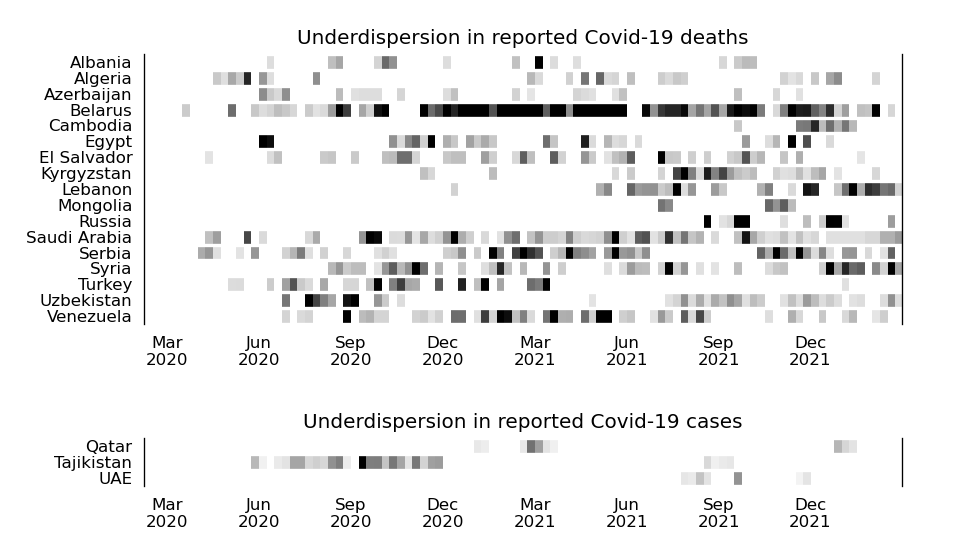

In [11]:
countries_deaths = [renames[c] if c in renames else c for c in countries[deaths_countries_flagged]]
countries_cases  = [renames[c] if c in renames else c for c in countries[cases_countries_flagged]]

plt.figure(figsize=(8, 4.5))
plt.set_cmap('Greys')

ax = plt.axes([.15,.4,.79,.5])
plt.title('Underdispersion in reported Covid-19 deaths')

deaths_ratios_masked = deaths_ratios.copy()
deaths_ratios_masked[deaths_tests==0] = 0

plt.imshow(deaths_ratios_masked[deaths_countries_flagged], aspect='auto', vmin=0, vmax=20)
plt.yticks(np.arange(len(countries_deaths)), countries_deaths)
plt.xticks(np.arange(3.5,95,12), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
                                  'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_deaths)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks-.5])
    
ax = plt.axes([.15,.1,.79,.5/len(countries_deaths)*len(countries_cases)])

cases_ratios_masked = cases_ratios.copy()
cases_ratios_masked[cases_tests==0] = 0

plt.title('Underdispersion in reported Covid-19 cases')
plt.imshow(cases_ratios_masked[cases_countries_flagged], aspect='auto')
plt.yticks(np.arange(len(countries_cases)), countries_cases)
plt.xticks(np.arange(3.5,95,12), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
                                  'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_cases)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks-.5])
    
sns.despine(bottom=True, right=False)

plt.savefig('img/testing-old.png', dpi=200)
plt.savefig('img/testing-old.pdf')

<IPython.core.display.Javascript object>


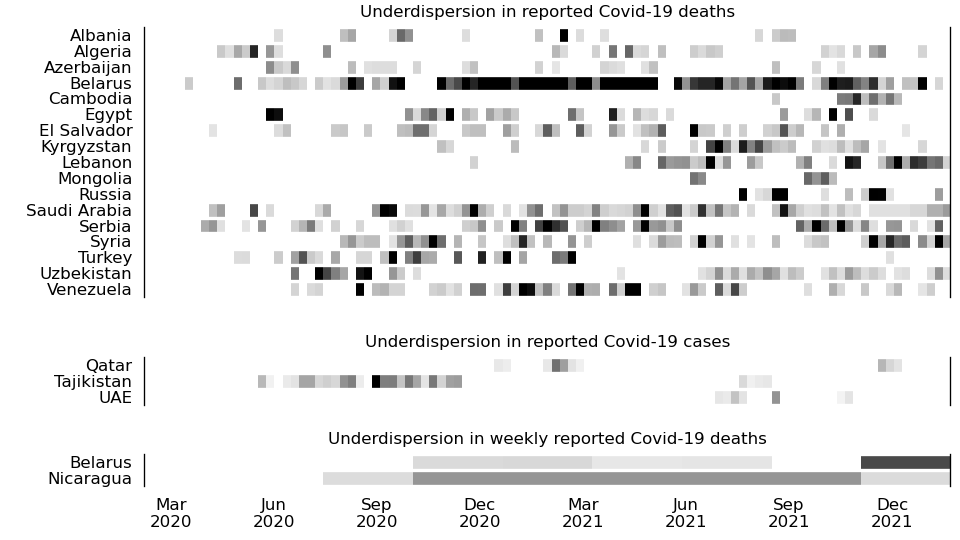

In [37]:
countries_deaths = [renames[c] if c in renames else c for c in countries[deaths_countries_flagged]]
countries_cases  = [renames[c] if c in renames else c for c in countries[cases_countries_flagged]]
countries_deaths_weekly = [renames[c] if c in renames else c for c in countries[deaths_countries_flagged_weekly]]

plt.figure(figsize=(8, 4.5))
plt.set_cmap('Greys')

ax = plt.axes([.15, .45, .84, .5])
plt.title('Underdispersion in reported Covid-19 deaths', fontsize=10)

deaths_ratios_masked = deaths_ratios.copy()
deaths_ratios_masked[deaths_tests==0] = 0

plt.imshow(deaths_ratios_masked[deaths_countries_flagged], aspect='auto', vmin=0, vmax=20)
plt.yticks(np.arange(len(countries_deaths)), countries_deaths)
plt.xticks([])#np.arange(3.5,95,12), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
#                                   'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_deaths)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks-.5])

#####################
ax = plt.axes([.15, .1, .84, .5/len(countries_deaths)*len(countries_deaths_weekly)])

deaths_ratios_masked_weekly = deaths_ratios_weekly.copy()
deaths_ratios_masked_weekly[deaths_tests_weekly==0] = 0

plt.imshow(deaths_ratios_masked_weekly[deaths_countries_flagged_weekly], aspect='auto', vmin=0, vmax=20)
plt.yticks(np.arange(len(countries_deaths_weekly)), countries_deaths_weekly)
plt.xticks([])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_deaths_weekly)):
    plt.plot([0, nweeks/10], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks/10-.5])

# plt.text(.6, .8, '(weekly)')

plt.title('Underdispersion in weekly reported Covid-19 deaths', fontsize=10)

plt.xticks(np.arange(.8, 9.8, 1.15), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
                                  'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)
    
######################
ax = plt.axes([.15, .25, .84, .5/len(countries_deaths)*len(countries_cases)])

cases_ratios_masked = cases_ratios.copy()
cases_ratios_masked[cases_tests==0] = 0

plt.title('Underdispersion in reported Covid-19 cases', fontsize=10)
plt.imshow(cases_ratios_masked[cases_countries_flagged], aspect='auto')
plt.yticks(np.arange(len(countries_cases)), countries_cases)

for i in range(-1, len(countries_cases)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xticks([])
plt.tick_params(left=False, bottom=False)
    
plt.xlim([.5, nweeks-.5])
    
sns.despine(bottom=True, right=False)

plt.savefig('img/testing.png', dpi=200)
plt.savefig('img/testing.pdf')

In [21]:
def showline(country, d, spacing=[0,0]):
    name = renames[country] if country in renames else country
    print(f'{name:15}', end='')
    
    spaceL = ' ' * spacing[0]
    spaceR = ' ' * spacing[1]
    for i in range(d.size):
        if d[i]==1:
            print(spaceL + '*' + spaceR, end='')
        else:
            print(spaceL + '.' + spaceR, end='')
    print('')        

print('Testing reported Covid-19 cases and deaths for underdispersion compared to Poisson, based on the WHO data. Each')
print(f'dot is one week, {nweeks} weeks in total. Asterisks denote p<0.05. Only countries with at least 15 weeks with p<0.05 ')
print('undispersion, or at least 4 weeks in a row, are shown. Summed weekly counts are separately tested for under-')
print('dispersion in chunks of 10 weeks; countries with at least 5 significant weeks are shown.')
print('')
print('')

print('  == REPORTED DEATHS ==')
for country_num, country in enumerate(countries):
    if deaths_countries_flagged[country_num]:
        showline(country, deaths_tests[country_num])
print('')

print('  == REPORTED CASES ==')
for country_num, country in enumerate(countries):
    if cases_countries_flagged[country_num]:
        showline(country, cases_tests[country_num])
print('')

print('  == REPORTED DEATHS PER WEEK ==')
for country_num, country in enumerate(countries):
    if deaths_countries_flagged_weekly[country_num]:
        showline(country, deaths_tests_weekly[country_num], (4,5))
print('')

# print('== CASES WEEKLY ==')
# for country_num, country in enumerate(countries):
#     if cases_countries_flagged_weekly[country_num]:
#         showline(country, cases_tests[country_num], 3)
# print('')

print('     | Jan Feb Mar Apr  May Jun  Jul Aug  Sep Oct Nov Dec | Jan Feb Mar Apr  May Jun Jul Aug  Sep Oct Nov Dec | Jan')
print('     |                        2020                        |                        2021                       |    ')

Testing reported Covid-19 cases and deaths for underdispersion compared to Poisson, based on the WHO data. Each
dot is one week, 100 weeks in total. Asterisks denote p<0.05. Only countries with at least 15 weeks with p<0.05 
undispersion, or at least 4 weeks in a row, are shown. Summed weekly counts are separately tested for under-
dispersion in chunks of 10 weeks; countries with at least 5 significant weeks are shown.


  == REPORTED DEATHS ==
Albania        .................*.......**....***......*........*..*.*..*..................*.***...................
Algeria        ..........*****.**.....*...........................**...*.*.***.*...****............***.*.**....*...
Azerbaijan     ................****......*.****..*.....**.......*.*.....***..**..............*....*..*.............
Belarus        ......*.....*..******.******.****....***************************..****************.**********.***.*.
Cambodia       ........................................................................

## Mean / variance ratios

In [22]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,country in enumerate(countries):
    plt.sca(ax1)
    plt.plot(deaths_ratios[i], '.-')

    plt.sca(ax2)
    plt.plot(cases_ratios[i], '.-')
    
# plt.sca(ax1)
# plt.plot(deaths_ratios[countries=='Iran (Islamic Republic of)'].ravel(), 'k.-')

sns.despine()
plt.tight_layout()

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,country in enumerate(countries):
    plt.sca(ax1)
    plt.plot(deaths_ratios_weekly[i], '.-')

    plt.sca(ax2)
    plt.plot(cases_ratios_weekly[i], '.-')
    
sns.despine()
plt.tight_layout()

<IPython.core.display.Javascript object>

In [24]:
for x in [np.mean(deaths_ratios, axis=1),
          np.max(deaths_ratios, axis=1),
          np.mean(cases_ratios, axis=1),
          np.max(cases_ratios, axis=1),
          np.mean(deaths_ratios_weekly, axis=1),
          np.max(deaths_ratios_weekly, axis=1),
          np.mean(cases_ratios_weekly, axis=1),
          np.max(cases_ratios_weekly, axis=1)]:

    ind = np.argsort(x)[::-1][:5]
    for i in ind:
        name = renames[countries[i]] if countries[i] in renames else countries[i]
        print(f'{name:15} {x[i]:.2f}')
    print('')

Belarus         17.20
Serbia          6.82
Saudi Arabia    6.25
Venezuela       5.99
Syria           5.49

Belarus         100.00
Russia          86.75
Venezuela       80.00
Turkey          48.47
Serbia          43.30

Tajikistan      4.73
Syria           1.95
Egypt           1.94
Qatar           1.50
UAE             1.04

Tajikistan      39.96
Egypt           29.86
Qatar           25.15
UAE             20.38
Syria           16.61

Nicaragua       6.20
Belarus         3.65
Tajikistan      1.40
Anguilla        1.00
Tuvalu          1.00

Belarus         15.47
Nicaragua       10.00
Tajikistan      6.92
UAE             3.14
Senegal         2.93

Tuvalu          1.00
Niue            1.00
Cook Islands    1.00
Saint Helena    1.00
Micronesia (Federated States of) 1.00

Tajikistan      5.86
Nicaragua       4.52
Brunei Darussalam 2.81
Cayman Islands  1.36
New Caledonia   1.18



In [25]:
maxmeanratio = np.amax(np.concatenate((
    np.mean(deaths_ratios, axis=1, keepdims=True),
    np.mean(cases_ratios, axis=1, keepdims=True),
    np.mean(deaths_ratios_weekly, axis=1, keepdims=True),
    np.mean(cases_ratios_weekly, axis=1, keepdims=True)),
        axis=1), axis=1)

In [26]:
ind = np.argsort(maxmeanratio)[::-1]

for i in ind:
    if maxmeanratio[i] > 2.5:
        name = renames[countries[i]] if countries[i] in renames else countries[i]
        print(f'{name:15} {maxmeanratio[i]:.1f}')

Belarus         17.2
Serbia          6.8
Saudi Arabia    6.2
Nicaragua       6.2
Venezuela       6.0
Syria           5.5
Tajikistan      4.7
El Salvador     4.2
Egypt           4.2
Turkey          4.1
Uzbekistan      3.9
Russia          3.9
Lebanon         3.8
Kyrgyzstan      3.4
Algeria         3.1
Azerbaijan      2.6
Albania         2.6


In [27]:
# Export as clean CSV

df_ratios = pd.DataFrame(
    np.concatenate(
        (
            np.mean(deaths_ratios, axis=1, keepdims=True),
            np.mean(cases_ratios, axis=1, keepdims=True),
            np.mean(deaths_ratios_weekly, axis=1, keepdims=True),
            np.mean(cases_ratios_weekly, axis=1, keepdims=True),
            maxmeanratio[:, np.newaxis]
        ),
        axis=1),
    index=countries,
    columns=['Underdispersion ratio (cases, daily, mean over weeks)',
             'Underdispersion ratio (deaths, daily, mean over weeks)',
             'Underdispersion ratio (cases, weekly, mean over 7-week blocks)',
             'Underdispersion ratio (deaths, weekly, mean over 7-week blocks)',
             'Underdispersion ratio (max)'])

df_ratios.to_csv('underdispersion-ratios.csv', float_format='%.2f')

## Relationship to the undercount based on excess mortality

In [28]:
# ex = pd.read_csv('https://raw.githubusercontent.com/dkobak/excess-mortality/main/excess-mortality.csv')
ex = pd.read_csv('frozen-data/excess-mortality.csv')

con = ex['Country'].values
und = ex['Undercount ratio'].values

wmd2who = {'Moldova':'Republic of Moldova',
           'Russia': 'Russian Federation',
           'Bosnia': 'Bosnia and Herzegovina',
           'Bolivia': 'Bolivia (Plurinational State of)',
           'United States': 'United States of America',
           'United Kingdom': 'The United Kingdom',
           'Kosovo': 'Kosovo[1]',
           'Iran': 'Iran (Islamic Republic of)',
           'South Korea': 'Republic of Korea',
           'Brunei': 'Brunei Darussalam',
           'Palestine': 'occupied Palestinian territory, including east Jerusalem'}

con = np.array([c if c not in wmd2who else wmd2who[c] for c in con])
print('Not found in the WHO dataset: ', con[~np.isin(con, countries)])

undercounts = np.zeros(countries.size) * np.nan
for i,c in enumerate(countries):
    if c in con:
        undercounts[i] = und[con==c]
        if np.isnan(und[con==c]):
            undercounts[i] = 1
        
print(np.sum(~np.isnan(undercounts)))

Not found in the WHO dataset:  ['Hong Kong' 'Macao' 'Taiwan' 'Transnistria']
113


In [29]:
signif = (
    deaths_countries_flagged 
    | cases_countries_flagged 
    | deaths_countries_flagged_weekly
    | cases_countries_flagged_weekly
)

In [30]:
plt.figure(figsize=(5,4))
plt.scatter(maxmeanratio[~signif], undercounts[~signif], c='k', s=5)
plt.scatter(maxmeanratio[signif], undercounts[signif], c='r', s=5)
plt.yscale('log')

plt.xlabel('Underdispersion index (mean / variance)')
plt.ylabel('Undercount ratio\n(excess deaths / reported Covid-19 deaths)')

shorten = {'Belarus': 'BY',
           'Nicaragua': 'NI',
           'Tajikistan': 'TJ',
           'Uzbekistan': 'UZ',
           'Egypt': 'EG',
           'El Salvador': 'SV',
           'Russian Federation': 'RU',
           'Lebanon': 'LB',
           'Republic of Moldova': 'MD',
           'Azerbaijan': 'AZ',
           'Kyrgyzstan': 'KG',
           'Serbia': 'RS',
           'Albania': 'AL',
           'Kazakhstan': 'KZ',
           'Monaco': 'MC',
           'Kuwait': 'KW',
           'Mongolia': 'MN',
           'Qatar': 'QA',
           'Algeria': 'AL',
          }

deltas = {'RU': [0, .8], 'AZ': [-.5, 1.05], 'AL': [-.5, .7], 'QA': [0,.8]}

ind = (maxmeanratio > 2.5) & ~np.isnan(undercounts) & signif
ind = ~np.isnan(undercounts) & signif
for i in np.where(ind)[0]:
    if shorten[countries[i]] in deltas:
        d = deltas[shorten[countries[i]]]
    else:
        d = [0, 1]
    
    plt.text(maxmeanratio[i]+.2 + d[0], undercounts[i] * 1.05 * d[1],
             shorten[countries[i]], fontsize=8, color='r')
    
sns.despine()
plt.tight_layout()

rho = np.corrcoef(maxmeanratio[~np.isnan(undercounts)], undercounts[~np.isnan(undercounts)])[0,1]
plt.text(15, .2, fr'$\rho={rho:.2f}$', fontsize=10)

plt.yticks([1,10,100],['1','10','100'])

plt.savefig('img/correlation.png', dpi=200)
plt.savefig('img/correlation.pdf', dpi=200)

<IPython.core.display.Javascript object>

## Russian regions

In [11]:
# https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw

# df = pd.read_csv('https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw/export?format=csv&gid=375550280')
df = pd.read_csv('frozen-data/StopCoronaRF - died.csv')

count = 0
print('== DEATHS ==')
for row in range(df.shape[0]):
    t = df.values[row,1:]
    t = np.diff(t[::-1])
    t[t<0] = 0
    
    a = np.where(df.columns[1:][::-1] == '30.03.2020')[0][0]
    b = np.where(df.columns[1:][::-1] == enddate[8:]+'.'+enddate[5:7]+'.'+enddate[:4])[0][0]
    ind = np.arange(a-1, b+1-1)
    t = t[ind]
    t = np.concatenate((np.zeros(28), t)) # append four weeks of zeros
    
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{df.values[row,0][:15]:15}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')
        
print(f'{count}/{df.shape[0]} regions')

== DEATHS ==
Алтайский край .........................................*..*.*.*.**............*.....*.**..****..*...**************
Астраханская об.....................*.*............*****..**.*.*****.**************.**.***********.****.***********
Белгородская об..........................................*.**.*....*.**********......*.*.*.**...***.***..***.******
Брянская област.....................................................................*....***.****.****.**.**.**.***
Владимирская об...............*.......*......*...............******.**....................................*.......*
Волгоградская о..........................***....*...*****.***.****.********.**.********.*********.*.*********.****.
Вологодская обл.................................................***..****************.*.********.***.*...*.....*...
Воронежская обл......................................................*..........*.........................****.....
Забайкальский к.................................**.........

In [13]:
# df = pd.read_csv('https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw/export?format=csv&gid=1771324359')
df = pd.read_csv('frozen-data/StopCoronaRF - infected.csv')

count = 0
which = np.zeros(df.shape[0]).astype(bool)

print('== CASES ==')
for row in range(df.shape[0]):
    t = df.values[row,1:]
    t = np.diff(t[::-1])
    
    a = np.where(df.columns[1:][::-1] == '30.03.2020')[0][0]
    b = np.where(df.columns[1:][::-1] == enddate[8:]+'.'+enddate[5:7]+'.'+enddate[:4])[0][0]
    ind = np.arange(a-1, b+1-1)
    t = t[ind]
    t = np.concatenate((np.zeros(28), t)) # append four weeks of zeros
    
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        which[row] = True
        
        print(f'{df.values[row,0][:15]:15}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')
        
print('')
print(f'{count}/{df.shape[0]} regions')
print(f'Passed: {df.values[:,0][~which]}')

== CASES ==
Алтайский край ..............***......*.*****..*.*********************************....************.....*******.....
Амурская област...................**.**..**.*.....************.*..*.************......***************..*******..***
Архангельская о................*.*.................*******.*.***...*.*********.**...*.****.*******.*..****.*.*.....
Астраханская об....................*..*..........******.****************.*.*.***........*******..*..***********....
Белгородская об............*****...**.*****..*..*..**************..***************.**..*********.*...********......
Брянская област...........****.*...........*......***...********..*********.******..****.**.****......**...****.*..
Владимирская об.............*.*****.********..*.***.***.***********..*************....**********....*********......
Волгоградская о...............*******.*..***...********.********.*..***************....**************.*****........
Вологодская обл.......*........**.****.******...**.*...***.*

Тульская област...........***.****..***********...***..*********.********.********..**************....**********...
Тюменская облас..................*.***.****.*..*.****************.***********..***....*************.***********....
Удмуртская Респ...............***.*...**......*..**********.**..*******************...***.*******...*****..*...*...
Ульяновская обл.............*..*******..**.**.****************.*.*.*****************...*************..****..**.*...
Хабаровский кра............**.*....*.......*......*...*****.***.....**.*...**.........**************...*.*.***.....
Ханты-Мансийски.................*.........*..*.************..*...*.*****.*****....*...***.******.***.*********.....
Челябинская обл...................**..**..**..**..*.*..**********...***************...***************..******......
Чеченская Респу.........****.*........**.*.*.***.......***.......****************......***.*...*****.*****.***.....
Чукотский автон.........................................................

## US states

There are currently 60 public health jurisdictions reporting cases of COVID-19. This includes the 50 states, the District of Columbia, New York City, the U.S. territories of American Samoa, Guam, the Commonwealth of the Northern Mariana Islands, Puerto Rico, and the U.S Virgin Islands as well as three independent countries in compacts of free association with the United States, Federated States of Micronesia, Republic of the Marshall Islands, and Republic of Palau. New York State’s reported case and death counts do not include New York City’s counts as they separately report nationally notifiable conditions to CDC.

In [42]:
# df = pd.read_csv('https://data.cdc.gov/api/views/9mfq-cb36/rows.csv')

df = pd.read_csv('frozen-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

print(np.unique(df['state']).size)

60


In [43]:
print('== DEATHS ==')
for state in np.unique(df['state']):
    print('.', end='')
    dates = df[df['state']==state]['submission_date'].values
    dates = np.array([d[6:]+'-'+d[:2]+'-'+d[3:5] for d in dates])
    ind = np.argsort(dates)
    dates = dates[ind]
    t = df[df['state']==state]['new_death'].values
    t = t[ind]
    
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    t = t[ind]
   
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{state[:20]:20}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')


== DEATHS ==
............................................................

In [44]:
print('== CASES ==')
for state in np.unique(df['state']):
    print('.', end='')
    dates = df[df['state']==state]['submission_date'].values
    dates = np.array([d[6:]+'-'+d[:2]+'-'+d[3:5] for d in dates])
    ind = np.argsort(dates)
    dates = dates[ind]
    t = df[df['state']==state]['new_case'].values
    t = t[ind]
    
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    t = t[ind]
   
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{state[:20]:20}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')

== CASES ==
............................................................